In [1]:
#Imports
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from json import loads
from sklearn import *

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

In [2]:
# dataset
train1_data = pd.read_csv('tmdb/TMDB_10000_Popular_Movies.csv')
train2_data =  pd.read_csv('tmdb/TMDB_7000_Top_Rated_Movies.csv')
train_data = train1_data.append(train2_data)
train_data = train_data.drop_duplicates(subset='TMDb_Id')
print(train1_data.shape, train2_data.shape, train_data.shape)

(10000, 22) (7101, 22) (10649, 22)


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10649 entries, 0 to 7093
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TMDb_Id               10649 non-null  int64  
 1   IMDb_Id               10578 non-null  object 
 2   Title                 10649 non-null  object 
 3   Original_Title        10649 non-null  object 
 4   Overview              10609 non-null  object 
 5   Genres                10580 non-null  object 
 6   Cast                  10596 non-null  object 
 7   Crew                  10636 non-null  object 
 8   Collection            10648 non-null  object 
 9   Release_Date          10646 non-null  object 
 10  Release_Status        10648 non-null  object 
 11  Original_Language     10649 non-null  object 
 12  Languages_Spoken      10565 non-null  object 
 13  Runtime               10634 non-null  float64
 14  Tagline               7862 non-null   object 
 15  Popularity          

In [4]:
train_data = train_data.dropna()

In [5]:
# EDA/preprocessing

In [7]:
top_N = 10
casts = {}
for i, revenue in zip(train_data['Cast'],train_data['Revenue']):
    try:
        for cast in map(lambda x:x.strip(), i.split('|')):
            casts[cast] = casts.get(cast, 0) + revenue
    except:
        print(i)

top_cast = [i[0] for i in sorted(casts.items(), key=lambda x:-x[1])[:top_N]]



cast_encoding = []
for i in train_data['Cast']:
    flag = False
    encoded_row = [0]*(top_N+1)
    for index, cast in enumerate(top_cast):
        if cast[0] in i:
            encoded_row[index] = 1
            flag = True
    if (not flag): encoded_row[-1]=1
    cast_encoding.append(encoded_row)


one_hot_cast = pd.DataFrame(cast_encoding, columns=top_cast+['other'])
one_hot_cast.index = train_data.index

train_data = train_data.join(one_hot_cast)

In [8]:
train_data.drop(columns = ['TMDb_Id'], axis=1).describe()

,Runtime,Popularity,Rating_average,Rating_Count,Budget,Revenue,Stan Lee,Samuel L. Jackson,Frank Welker,Warwick Davis,Jess Harnell,Scarlett Johansson,Robert Downey Jr.,John Ratzenberger,Chris Evans,Andy Serkis,other
count,8182.000000,8182.000000,8182.000000,8182.000000,8.182000e+03,8.182000e+03,8182.000000,8182.000000,8182.000000,8182.000000,8182.000000,8182.000000,8182.000000,8182.000000,8182.000000,8182.000000,8182.000000
mean,105.940112,13.703239,6.425507,1246.205451,2.352207e+07,7.078893e+07,0.938890,0.938890,0.708384,0.736006,0.919091,0.938890,0.877536,0.919091,0.914813,0.889636,0.000856
std,21.374361,10.670395,0.968621,2184.444782,3.872208e+07,1.616703e+08,0.239546,0.239546,0.454534,0.440823,0.272712,0.239546,0.327841,0.272712,0.279177,0.313362,0.029239
min,0.000000,0.600000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,93.000000,9.887250,5.900000,209.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,103.000000,11.717500,6.500000,444.000000,7.820652e+06,1.200000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,116.000000,14.456250,7.100000,1217.000000,3.000000e+07,6.764000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,366.000000,463.487000,10.000000,25159.000000,3.800000e+08,2.797801e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
train_data = train_data[(train_data['Budget']!=0) & (train_data['Revenue']!=0) & (train_data['Runtime']!=0) & (train_data['Rating_Count']!=0)]
train_data.head()

,TMDb_Id,IMDb_Id,Title,Original_Title,Overview,Genres,Cast,Crew,Collection,Release_Date,...,Samuel L. Jackson,Frank Welker,Warwick Davis,Jess Harnell,Scarlett Johansson,Robert Downey Jr.,John Ratzenberger,Chris Evans,Andy Serkis,other
0,419704,tt2935510,Ad Astra,Ad Astra,"The near future, a time when both hope and har...",Drama | Science Fiction,Brad Pitt | Tommy Lee Jones | Ruth Negga | Joh...,Brad Pitt | Arnon Milchan | Gary Rydstrom | Ga...,Single,2019-09-17,...,1,1,1,1,1,1,1,1,1,0
1,338762,tt1634106,Bloodshot,Bloodshot,"After he and his wife are murdered, marine Ray...",Action | Science Fiction,Vin Diesel | Eiza González | Sam Heughan | Tob...,John Papsidera | Matthew Vaughn | Jim May | Ne...,Single,2020-03-05,...,1,0,0,1,1,1,1,1,1,0
3,102899,tt0478970,Ant-Man,Ant-Man,Armed with the astonishing ability to shrink i...,Action | Adventure | Science Fiction,Paul Rudd | Michael Douglas | Evangeline Lilly...,David Lazan | Jackie Burch | Sala Baker | Sala...,Ant-Man Collection,2015-07-14,...,1,1,1,1,1,1,1,1,1,0
4,76285,tt1854564,Percy Jackson: Sea of Monsters,Percy Jackson: Sea of Monsters,"In their quest to confront the ultimate evil, ...",Adventure | Fantasy | Family,Logan Lerman | Alexandra Daddario | Douglas Sm...,Mark Goldblatt | Shelly Johnson | Karen Rosenf...,Percy Jackson Collection,2013-08-07,...,1,1,1,1,1,1,1,1,1,0
5,495764,tt7713068,Birds of Prey (and the Fantabulous Emancipatio...,Birds of Prey (and the Fantabulous Emancipatio...,"Harley Quinn joins forces with a singer, an as...",Action | Comedy | Crime,Margot Robbie | Ewan McGregor | Mary Elizabeth...,K.K. Barrett | K.K. Barrett | Matthew Libatiqu...,Single,2020-02-05,...,1,1,1,1,1,1,1,1,1,0


In [10]:
train_data

,TMDb_Id,IMDb_Id,Title,Original_Title,Overview,Genres,Cast,Crew,Collection,Release_Date,...,Samuel L. Jackson,Frank Welker,Warwick Davis,Jess Harnell,Scarlett Johansson,Robert Downey Jr.,John Ratzenberger,Chris Evans,Andy Serkis,other
0,419704,tt2935510,Ad Astra,Ad Astra,"The near future, a time when both hope and har...",Drama | Science Fiction,Brad Pitt | Tommy Lee Jones | Ruth Negga | Joh...,Brad Pitt | Arnon Milchan | Gary Rydstrom | Ga...,Single,2019-09-17,...,1,1,1,1,1,1,1,1,1,0
1,338762,tt1634106,Bloodshot,Bloodshot,"After he and his wife are murdered, marine Ray...",Action | Science Fiction,Vin Diesel | Eiza González | Sam Heughan | Tob...,John Papsidera | Matthew Vaughn | Jim May | Ne...,Single,2020-03-05,...,1,0,0,1,1,1,1,1,1,0
3,102899,tt0478970,Ant-Man,Ant-Man,Armed with the astonishing ability to shrink i...,Action | Adventure | Science Fiction,Paul Rudd | Michael Douglas | Evangeline Lilly...,David Lazan | Jackie Burch | Sala Baker | Sala...,Ant-Man Collection,2015-07-14,...,1,1,1,1,1,1,1,1,1,0
4,76285,tt1854564,Percy Jackson: Sea of Monsters,Percy Jackson: Sea of Monsters,"In their quest to confront the ultimate evil, ...",Adventure | Fantasy | Family,Logan Lerman | Alexandra Daddario | Douglas Sm...,Mark Goldblatt | Shelly Johnson | Karen Rosenf...,Percy Jackson Collection,2013-08-07,...,1,1,1,1,1,1,1,1,1,0
5,495764,tt7713068,Birds of Prey (and the Fantabulous Emancipatio...,Birds of Prey (and the Fantabulous Emancipatio...,"Harley Quinn joins forces with a singer, an as...",Action | Comedy | Crime,Margot Robbie | Ewan McGregor | Mary Elizabeth...,K.K. Barrett | K.K. Barrett | Matthew Libatiqu...,Single,2020-02-05,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9920,16007,tt0758742,Death Note,デスノート,"Light Yagami finds the ""Death Note,"" a noteboo...",Fantasy | Mystery | Thriller,Tatsuya Fujiwara | Kenichi Matsuyama | Erika T...,Shusuke Kaneko | Takeshi Obata | Tetsuya Oishi...,Death Note Collection,2006-06-17,...,1,1,0,0,1,1,0,1,1,0
9922,316002,tt1137470,Accidental Love,Accidental Love,A small town waitress gets a nail accidentally...,Comedy | Romance,Jake Gyllenhaal | Jessica Biel | James Marsden...,Judy Becker | Dennis Bradford | David O. Russe...,Single,2015-02-10,...,0,1,1,1,0,1,1,1,1,0
9925,31909,tt0091276,Invaders from Mars,Invaders from Mars,In this attempted remake of the classic 50s SF...,Adventure | Horror | Mystery | Science Fiction...,Hunter Carson | Karen Black | Timothy Bottoms ...,Dan O'Bannon | Leslie Dilley | Dana Lyman | Da...,Single,1986-01-01,...,1,1,1,1,1,1,1,1,1,0
9927,8193,tt0374900,Napoleon Dynamite,Napoleon Dynamite,A listless and alienated teenager decides to h...,Comedy,Jon Heder | Aaron Ruell | Jon Gries | Efren Ra...,John Swihart | Jared Hess | Jared Hess | Sean ...,Single,2004-06-11,...,1,0,0,1,1,1,1,0,1,0


In [11]:
train_data.drop(columns='TMDb_Id', axis=1).describe()

,Runtime,Popularity,Rating_average,Rating_Count,Budget,Revenue,Stan Lee,Samuel L. Jackson,Frank Welker,Warwick Davis,Jess Harnell,Scarlett Johansson,Robert Downey Jr.,John Ratzenberger,Chris Evans,Andy Serkis,other
count,4718.000000,4718.000000,4718.000000,4718.000000,4.718000e+03,4.718000e+03,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000,4718.000000
mean,110.333616,15.227671,6.508584,1911.129716,3.852109e+07,1.195253e+08,0.959941,0.959941,0.753073,0.789953,0.950403,0.959941,0.914582,0.950403,0.944044,0.909496,0.000212
std,20.432222,12.305679,0.835895,2664.205808,4.457167e+07,1.987648e+08,0.196119,0.196119,0.431269,0.407385,0.217134,0.196119,0.279532,0.217134,0.229861,0.286934,0.014559
min,26.000000,0.600000,2.600000,6.000000,1.000000e+00,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,96.000000,10.675250,6.000000,391.000000,9.100000e+06,1.611862e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,107.000000,12.665000,6.500000,897.000000,2.400000e+07,5.000625e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,120.000000,16.211250,7.100000,2253.250000,5.000000e+07,1.338019e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,248.000000,463.487000,8.800000,25159.000000,3.800000e+08,2.797801e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
train_data.head()

,TMDb_Id,IMDb_Id,Title,Original_Title,Overview,Genres,Cast,Crew,Collection,Release_Date,...,Samuel L. Jackson,Frank Welker,Warwick Davis,Jess Harnell,Scarlett Johansson,Robert Downey Jr.,John Ratzenberger,Chris Evans,Andy Serkis,other
0,419704,tt2935510,Ad Astra,Ad Astra,"The near future, a time when both hope and har...",Drama | Science Fiction,Brad Pitt | Tommy Lee Jones | Ruth Negga | Joh...,Brad Pitt | Arnon Milchan | Gary Rydstrom | Ga...,Single,2019-09-17,...,1,1,1,1,1,1,1,1,1,0
1,338762,tt1634106,Bloodshot,Bloodshot,"After he and his wife are murdered, marine Ray...",Action | Science Fiction,Vin Diesel | Eiza González | Sam Heughan | Tob...,John Papsidera | Matthew Vaughn | Jim May | Ne...,Single,2020-03-05,...,1,0,0,1,1,1,1,1,1,0
3,102899,tt0478970,Ant-Man,Ant-Man,Armed with the astonishing ability to shrink i...,Action | Adventure | Science Fiction,Paul Rudd | Michael Douglas | Evangeline Lilly...,David Lazan | Jackie Burch | Sala Baker | Sala...,Ant-Man Collection,2015-07-14,...,1,1,1,1,1,1,1,1,1,0
4,76285,tt1854564,Percy Jackson: Sea of Monsters,Percy Jackson: Sea of Monsters,"In their quest to confront the ultimate evil, ...",Adventure | Fantasy | Family,Logan Lerman | Alexandra Daddario | Douglas Sm...,Mark Goldblatt | Shelly Johnson | Karen Rosenf...,Percy Jackson Collection,2013-08-07,...,1,1,1,1,1,1,1,1,1,0
5,495764,tt7713068,Birds of Prey (and the Fantabulous Emancipatio...,Birds of Prey (and the Fantabulous Emancipatio...,"Harley Quinn joins forces with a singer, an as...",Action | Comedy | Crime,Margot Robbie | Ewan McGregor | Mary Elizabeth...,K.K. Barrett | K.K. Barrett | Matthew Libatiqu...,Single,2020-02-05,...,1,1,1,1,1,1,1,1,1,0


In [13]:
#Visualizations

In [14]:
countries = {}

for i in train_data['Country_of_Origin'].dropna(axis=0):
      for j in i.split('|'):
        countries[j] = countries.get(j,0)+1
          

<BarContainer object of 185 artists>

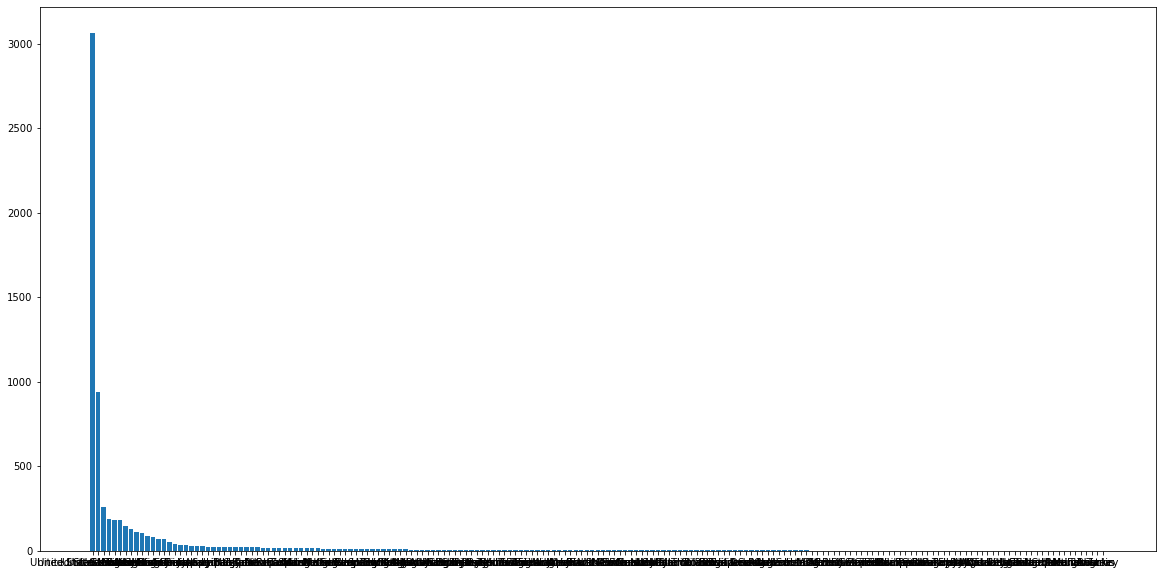

In [15]:
plt.figure(figsize=(20,10))
scountries = sorted(countries.items(), key=lambda x:-x[1])
country, count = zip(*scountries)
plt.bar(country, count)

In [16]:
# classify top 5 countries and others

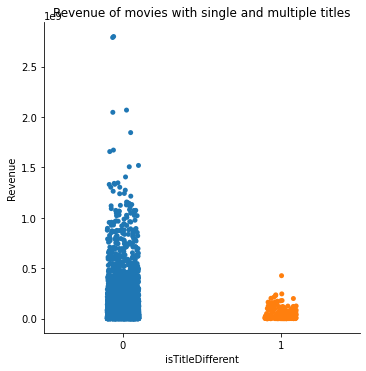

In [17]:
train_data['isTitleDifferent'] = 1
train_data.loc[ train_data['Original_Title'] == train_data['Title'] ,"isTitleDifferent"] = 0 
sns.catplot(x="isTitleDifferent", y="Revenue", data=train_data)
plt.title('Revenue of movies with single and multiple titles');

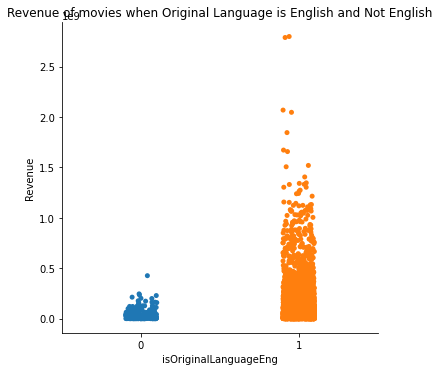

In [18]:
train_data['isOriginalLanguageEng'] = 0 
train_data.loc[ train_data['Original_Language'] == "en" ,"isOriginalLanguageEng"] = 1
sns.catplot(x="isOriginalLanguageEng", y="Revenue", data=train_data)
plt.title('Revenue of movies when Original Language is English and Not English');

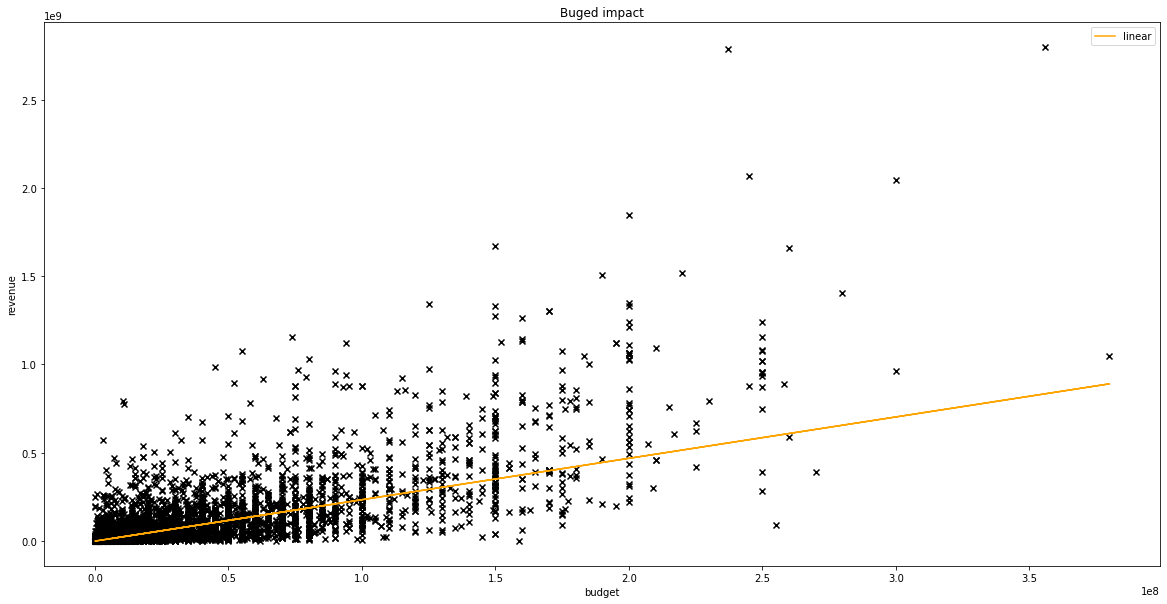

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(x = train_data['Budget'], y = train_data['Revenue'], marker = 'x', color = 'black')

# We fit a linear model
model = linear_model.HuberRegressor()
model.fit(X = np.array(train_data['Budget']).reshape(-1,1), y = train_data['Revenue'])
rev_pred = model.predict(np.array(train_data['Budget']).reshape(-1,1))

# We plot the fit 
plt.plot(train_data['Budget'], rev_pred, color = 'orange', label = 'linear')


plt.xlabel('budget')
plt.ylabel('revenue')
plt.title('Buged impact')
plt.legend()
plt.show()

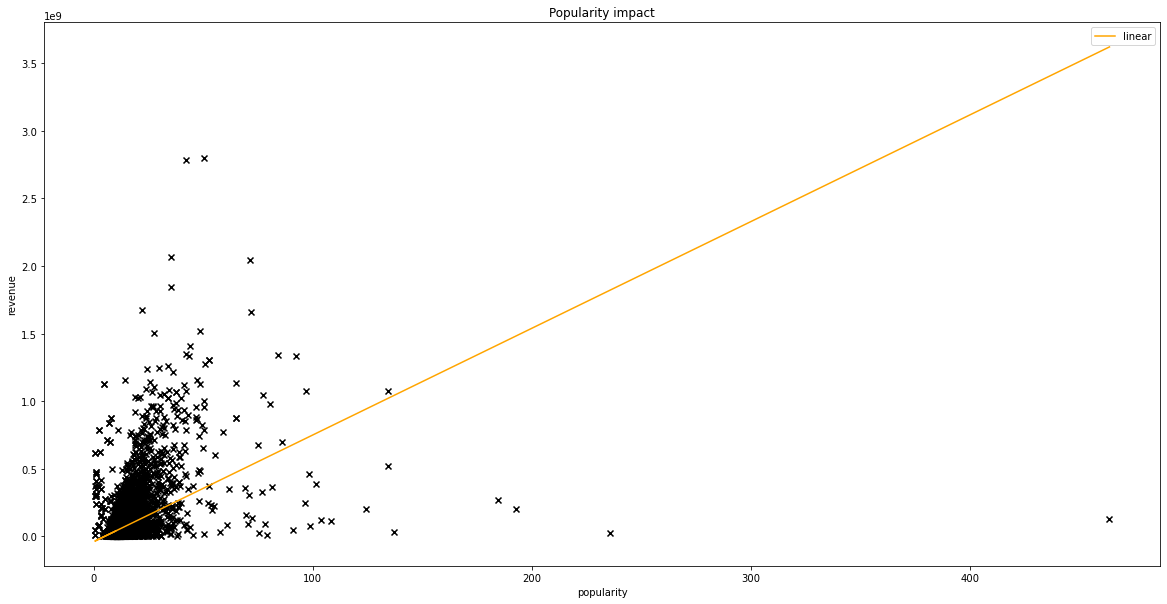

In [20]:
plt.figure(figsize=(20,10))
plt.scatter(x = train_data['Popularity'], y = train_data['Revenue'], marker = 'x', color = 'black')

# We fit a linear model
model = linear_model.HuberRegressor()
model.fit(X = np.array(train_data['Popularity']).reshape(-1,1), y = train_data['Revenue'])
rev_pred = model.predict(np.array(train_data['Popularity']).reshape(-1,1))

# We plot the fit 
plt.plot(train_data['Popularity'], rev_pred, color = 'orange', label = 'linear')

plt.xlabel('popularity')
plt.ylabel('revenue')
plt.title('Popularity impact')
plt.legend()
plt.show()

In [21]:
genres = pd.Series(list(set(", ".join(train_data['Genres'].unique().tolist()).split('|')))).str.split(",").tolist()#.str[1].str.split("'").str[0].tolist()
unique_genres = set()
for i in genres:
  for j in i:
    unique_genres.add(j.strip())

len(unique_genres)
#.split("|")#.str[1].str.split("|").str[0].tolist()

19

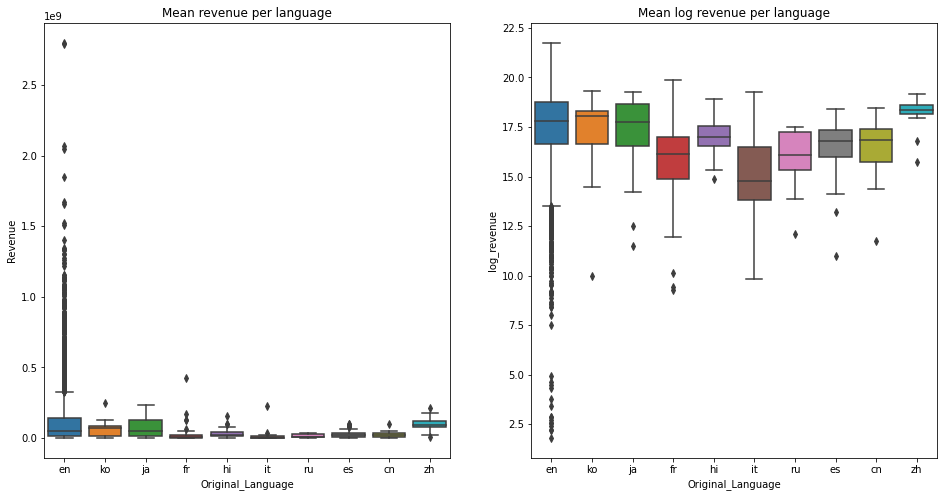

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
train_data['log_revenue'] = np.log1p(train_data['Revenue'])
sns.boxplot(x='Original_Language', y='Revenue', data=train_data.loc[train_data['Original_Language'].isin(train_data['Original_Language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='Original_Language', y='log_revenue', data=train_data.loc[train_data['Original_Language'].isin(train_data['Original_Language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

<ipython-input-23-92974d42268c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_df['genres_test'] = genres_df['Genres']
<ipython-input-23-92974d42268c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_df.genres_test[genres_df.genres_test.isnull()] = ''
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


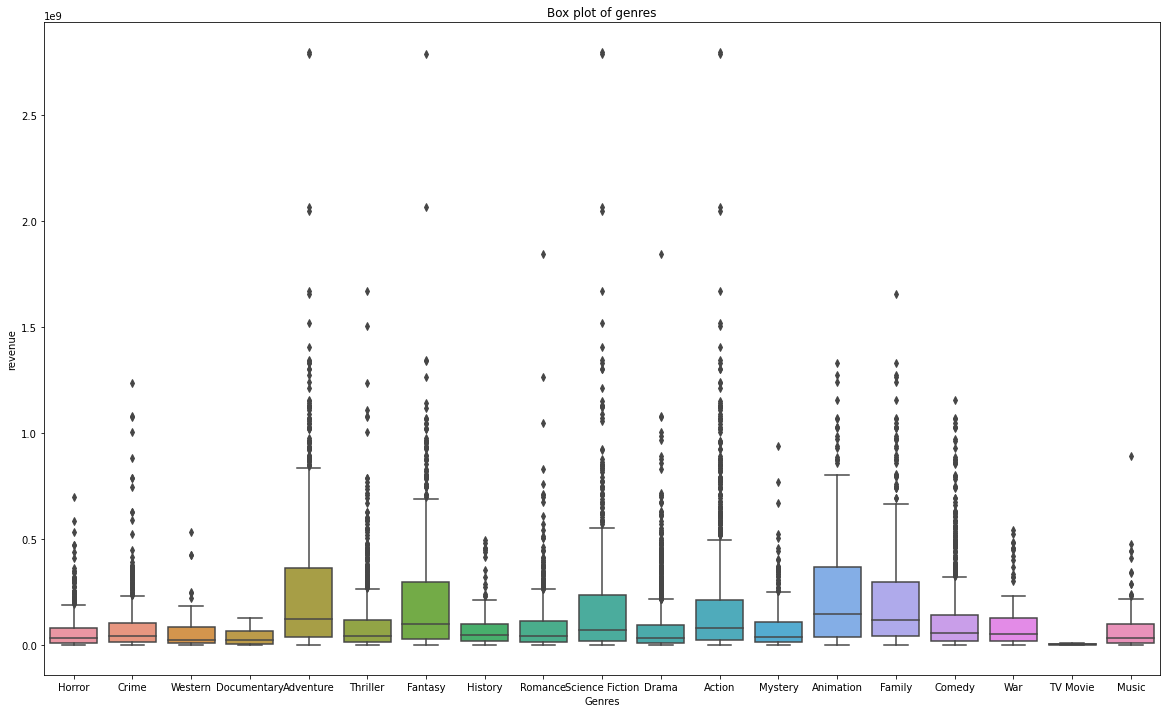

In [23]:
# "genres": Clean, EDA and create bools > True if belongs to a specific genre, False if not
genres_df = train_data[['Revenue', 'Genres']]
genres_df['genres_test'] = genres_df['Genres']

genres_df.genres_test[genres_df.genres_test.isnull()] = ''
genres_list = pd.Series(list(set(", ".join(genres_df.genres_test.unique().tolist()).split('|')))).str.split(",").tolist()

for i, genre in enumerate(unique_genres):
    genres_df[genre] = np.nan
    genres_df[genre][genres_df.genres_test.str.contains(genre)] = genres_df['Revenue'][genres_df.genres_test.str.contains(genre)]
genres_df.drop(columns=['Revenue', 'Genres', 'genres_test'], inplace=True)

plt.figure(figsize=(20,12))
sns.boxplot(data=genres_df)
plt.xlabel('Genres')
plt.ylabel('revenue')
plt.title('Box plot of genres')
plt.show()

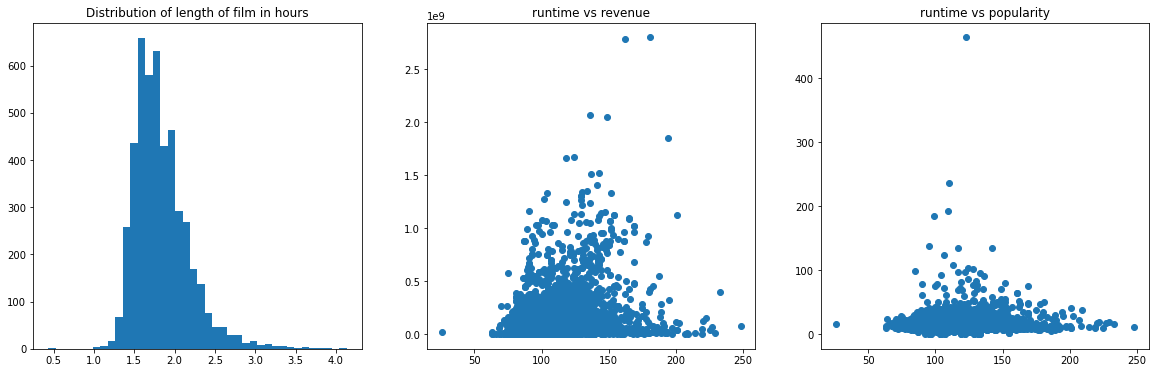

In [153]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train_data['Runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train_data['Runtime'].fillna(0), train_data['Revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train_data['Runtime'].fillna(0), train_data['Popularity'])
plt.title('runtime vs popularity');

<AxesSubplot:>

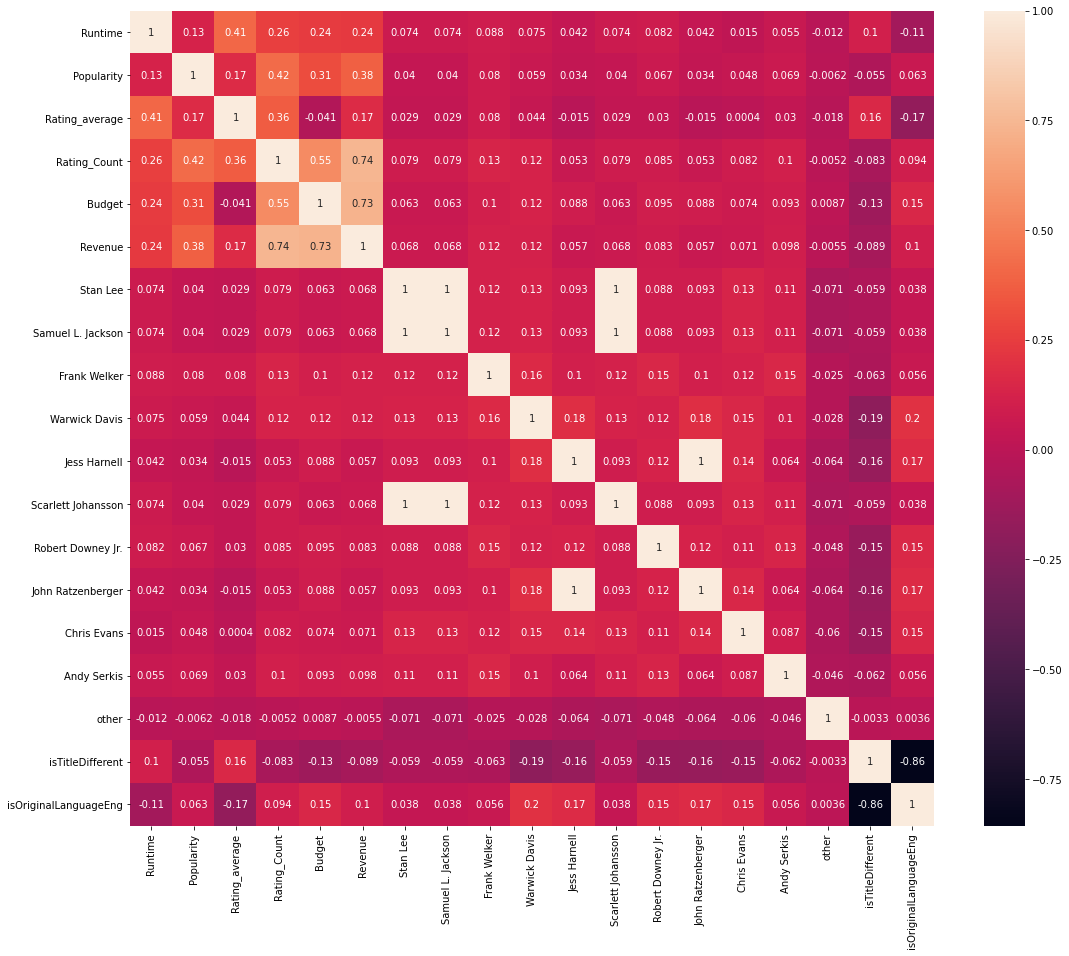

In [208]:
plt.figure(figsize=(18,15))
sns.heatmap(train_data.drop(columns=['TMDb_Id', 'log_revenue']).corr(), annot=True)

# Models

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [156]:
train_data.columns

Index(['TMDb_Id', 'IMDb_Id', 'Title', 'Original_Title', 'Overview', 'Genres',
       'Cast', 'Crew', 'Collection', 'Release_Date', 'Release_Status',
       'Original_Language', 'Languages_Spoken', 'Runtime', 'Tagline',
       'Popularity', 'Rating_average', 'Rating_Count', 'Production_Companies',
       'Country_of_Origin', 'Budget', 'Revenue', 'Stan Lee',
       'Samuel L. Jackson', 'Frank Welker', 'Warwick Davis', 'Jess Harnell',
       'Scarlett Johansson', 'Robert Downey Jr.', 'John Ratzenberger',
       'Chris Evans', 'Andy Serkis', 'other', 'isTitleDifferent',
       'isOriginalLanguageEng', 'log_revenue'],
      dtype='object')

In [157]:
drop_columns = ['TMDb_Id', 'IMDb_Id', 'Original_Title', 'Overview', 'Country_of_Origin', 'Languages_Spoken', 'Production_Companies', 'Tagline', 'Title', 'Cast', 'Crew', 'Release_Date', 'Genres' ,'Collection']
train_data = train_data.dropna()
x=pd.get_dummies(train_data.drop(columns=drop_columns, axis=1))

In [158]:
for i in unique_genres:
  x[i] = 0

for i in countries:
  x[i.strip()] = 0

for i in range(len(x)):
  for j in train_data['Genres'].iloc[i].split('|'):
      x[j.strip()].iloc[i]=1
    
  for j in train_data['Country_of_Origin'].iloc[i].split('|'):
      x[j.strip()].iloc[i]= 1
  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [159]:
x.head()

,Runtime,Popularity,Rating_average,Rating_Count,Budget,Revenue,Stan Lee,Samuel L. Jackson,Frank Welker,Warwick Davis,...,Uganda,Ghana,Croatia,Ukraine,Portugal,Monaco,Namibia,Liechtenstein,Angola,Belarus
0,123.0,463.487,5.9,2863,87500000.0,127175922.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,110.0,235.701,7.2,1384,42000000.0,24573617.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,117.0,134.294,7.1,13625,130000000.0,519311965.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,106.0,124.417,5.9,3547,90000000.0,199850315.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,109.0,192.582,7.1,2681,75000000.0,199158461.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [161]:
x=x.dropna()
x=x[x['Revenue']>=100000]
x=x[x['Budget']>=100000]

In [162]:
x

,Runtime,Popularity,Rating_average,Rating_Count,Budget,Revenue,Stan Lee,Samuel L. Jackson,Frank Welker,Warwick Davis,...,Uganda,Ghana,Croatia,Ukraine,Portugal,Monaco,Namibia,Liechtenstein,Angola,Belarus
0,123.0,463.487,5.9,2863,87500000.0,127175922.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,110.0,235.701,7.2,1384,42000000.0,24573617.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,117.0,134.294,7.1,13625,130000000.0,519311965.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,106.0,124.417,5.9,3547,90000000.0,199850315.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,109.0,192.582,7.1,2681,75000000.0,199158461.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9914,102.0,9.467,6.7,124,23000000.0,10827816.0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9920,126.0,7.617,6.9,327,20000000.0,27793200.0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9925,100.0,8.215,5.5,103,12000000.0,4884663.0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9927,95.0,7.716,6.8,1063,400000.0,46118097.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
X_train, X_test, y_train, y_test = train_test_split(x.drop('Revenue', axis=1), x['Revenue'], test_size=0.33, random_state=0)

In [164]:
X_train.shape, X_test.shape

((3098, 147), (1526, 147))

In [165]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [166]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test), lr.score(X_train, y_train)

(0.7173078797428235, 0.7447041854636236)

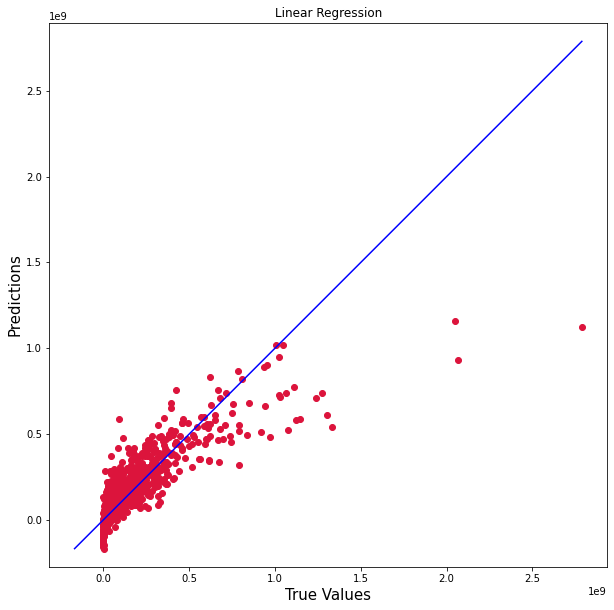

In [310]:
y_pred = lr.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Linear Regression')
plt.show()

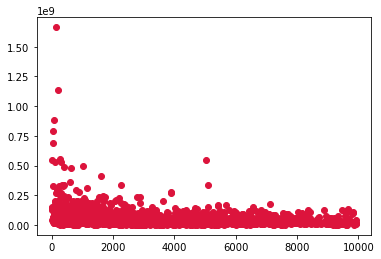

In [168]:
plt.plot(abs(y_test - y_pred), c='crimson', marker='o',  linestyle='')

In [169]:
print('Linear Regression RMSE, MAE')
mean_squared_error(y_pred, y_test, squared=False), mean_absolute_error(y_pred, y_test)

Linear Regression RMSE, MAE


(106268722.42322591, 60120427.01779315)

In [170]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0, max_depth=3)  
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=0)

In [171]:
regressor.score(X_test, y_test), regressor.score(X_train, y_train)

(0.9556930944520043, 0.962980012016669)

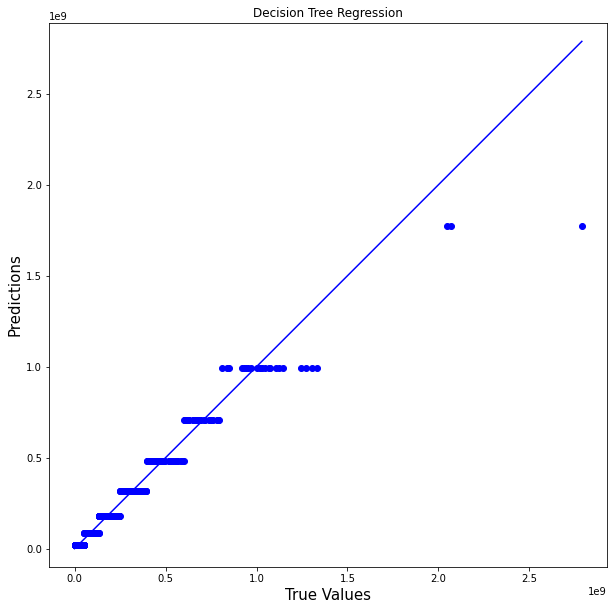

In [172]:
y_pred = regressor.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='blue')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Decision Tree Regression')
plt.show()


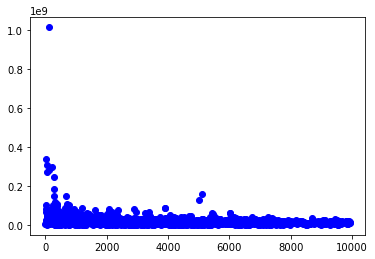

In [173]:
plt.plot(abs(y_test - y_pred), c='blue', marker='o',  linestyle='')

In [174]:
print('Decision tree Regressor RMSE, MAE')
mean_squared_error(y_pred, y_test, squared=False), mean_absolute_error(y_pred, y_test)

Decision tree Regressor RMSE, MAE


(42071143.617812976, 22058687.981937233)

In [175]:
from sklearn.ensemble import RandomForestRegressor
rforest = RandomForestRegressor(max_depth=5, random_state=0, criterion='mse')
rforest.fit(X_train, y_train)
rforest.score(X_test, y_test), rforest.score(X_train, y_train)

(0.9811497404481334, 0.9979577650283642)

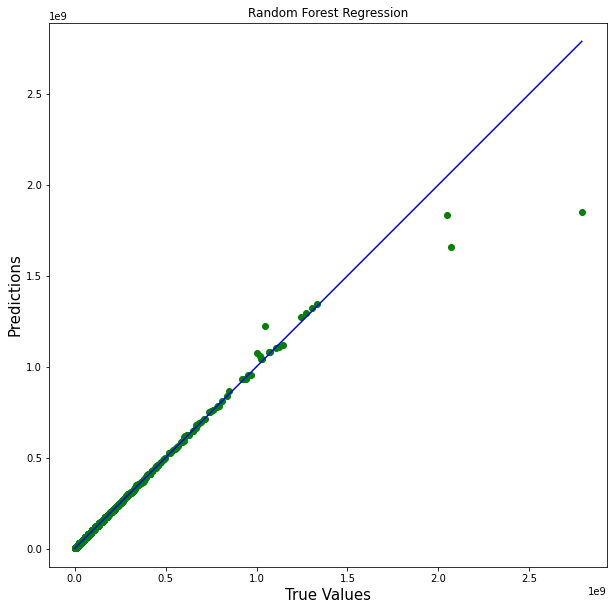

In [311]:
y_pred = rforest.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='g')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Random Forest Regression')
plt.axis('equal')
plt.show()

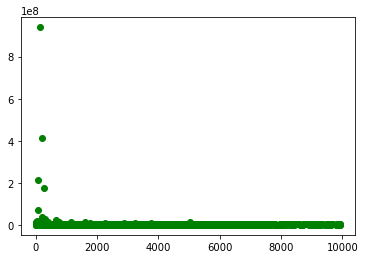

In [177]:
plt.plot(abs(y_test - y_pred), c='g', marker='o',  linestyle='')

In [178]:
print('random Forest RMSE, MAE')
mean_squared_error(y_pred, y_test, squared=False), mean_absolute_error(y_pred, y_test)

random Forest RMSE, MAE


(27441463.865783583, 3361622.62497971)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

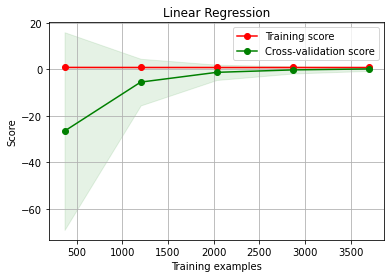

In [179]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(lr, 'Linear Regression', x.drop('Revenue', axis=1), x['Revenue'])

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

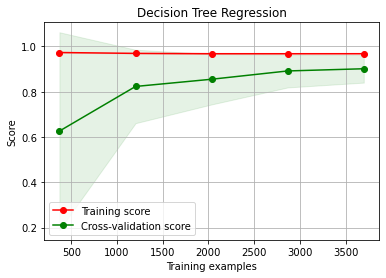

In [180]:
plot_learning_curve(regressor, 'Decision Tree Regression', x.drop('Revenue', axis=1), x['Revenue'])

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

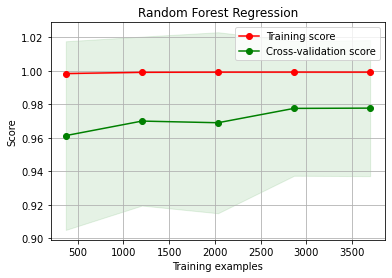

In [312]:
plot_learning_curve(rforest, 'Random Forest Regression', x.drop('Revenue', axis=1), x['Revenue'])

In [182]:
X_train.shape

(3098, 147)

# MLP Regressor

In [236]:
(147+1)/2

74.0

In [296]:
model = keras.Sequential([
    keras.layers.Dense(units=147, input_shape=(X_train.shape[1],), activation='linear'),
    keras.layers.Dense(units=74, input_shape=(X_train.shape[1],), activation='linear'),
    keras.layers.Dense(units=1, activation='linear')
])

In [297]:
model.compile(optimizer='adam', 
              loss=tf.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mean_squared_error', 'mean_absolute_error'])

history = model.fit(
    X_train.astype('float32'), y_train,
    epochs=1000,
    verbose=1
)

Epoch 1/1000
97/97 [==============================] - 1s 3ms/step - loss: 22797808813735936.0000 - rmse: 150989440.0000 - mean_squared_error: 22797808813735936.0000 - mean_absolute_error: 81112376.0000
Epoch 2/1000
97/97 [==============================] - 0s 3ms/step - loss: 18626285320273920.0000 - rmse: 136478144.0000 - mean_squared_error: 18626285320273920.0000 - mean_absolute_error: 78452160.0000
Epoch 3/1000
97/97 [==============================] - 0s 3ms/step - loss: 18591837535076352.0000 - rmse: 136351888.0000 - mean_squared_error: 18591837535076352.0000 - mean_absolute_error: 77482552.0000
Epoch 4/1000
97/97 [==============================] - 0s 2ms/step - loss: 18681084808003584.0000 - rmse: 136678768.0000 - mean_squared_error: 18681084808003584.0000 - mean_absolute_error: 78769624.0000
Epoch 5/1000
97/97 [==============================] - 0s 2ms/step - loss: 18936306797117440.0000 - rmse: 137609248.0000 - mean_squared_error: 18936306797117440.0000 - mean_absolute_error: 7708

97/97 [==============================] - 0s 2ms/step - loss: 18617826382184448.0000 - rmse: 136447152.0000 - mean_squared_error: 18617826382184448.0000 - mean_absolute_error: 77935600.0000
Epoch 82/1000
97/97 [==============================] - 0s 2ms/step - loss: 18562352584589312.0000 - rmse: 136243728.0000 - mean_squared_error: 18562352584589312.0000 - mean_absolute_error: 76996992.0000
Epoch 83/1000
97/97 [==============================] - 0s 2ms/step - loss: 18724710938312704.0000 - rmse: 136838256.0000 - mean_squared_error: 18724710938312704.0000 - mean_absolute_error: 78728464.0000
Epoch 84/1000
97/97 [==============================] - 0s 2ms/step - loss: 18514790116753408.0000 - rmse: 136069072.0000 - mean_squared_error: 18514790116753408.0000 - mean_absolute_error: 77646720.0000
Epoch 85/1000
97/97 [==============================] - 0s 2ms/step - loss: 18751069152608256.0000 - rmse: 136934544.0000 - mean_squared_error: 18751069152608256.0000 - mean_absolute_error: 77789152.0000

97/97 [==============================] - 0s 2ms/step - loss: 18390306932129792.0000 - rmse: 135610864.0000 - mean_squared_error: 18390306932129792.0000 - mean_absolute_error: 77641072.0000
Epoch 162/1000
97/97 [==============================] - 0s 2ms/step - loss: 18415900642246656.0000 - rmse: 135705200.0000 - mean_squared_error: 18415900642246656.0000 - mean_absolute_error: 77486808.0000
Epoch 163/1000
97/97 [==============================] - 0s 2ms/step - loss: 18567540905082880.0000 - rmse: 136262768.0000 - mean_squared_error: 18567540905082880.0000 - mean_absolute_error: 77045184.0000
Epoch 164/1000
97/97 [==============================] - 0s 2ms/step - loss: 18355154772295680.0000 - rmse: 135481200.0000 - mean_squared_error: 18355154772295680.0000 - mean_absolute_error: 77292016.0000
Epoch 165/1000
97/97 [==============================] - 0s 2ms/step - loss: 18493096236941312.0000 - rmse: 135989328.0000 - mean_squared_error: 18493096236941312.0000 - mean_absolute_error: 77145824.

97/97 [==============================] - 0s 2ms/step - loss: 18458328476680192.0000 - rmse: 135861424.0000 - mean_squared_error: 18458328476680192.0000 - mean_absolute_error: 77692752.0000
Epoch 241/1000
97/97 [==============================] - 0s 2ms/step - loss: 18187672522588160.0000 - rmse: 134861680.0000 - mean_squared_error: 18187672522588160.0000 - mean_absolute_error: 77063328.0000
Epoch 242/1000
97/97 [==============================] - 0s 2ms/step - loss: 18239480565596160.0000 - rmse: 135053616.0000 - mean_squared_error: 18239480565596160.0000 - mean_absolute_error: 76475360.0000
Epoch 243/1000
97/97 [==============================] - 0s 2ms/step - loss: 18156974243840000.0000 - rmse: 134747808.0000 - mean_squared_error: 18156974243840000.0000 - mean_absolute_error: 76293200.0000
Epoch 244/1000
97/97 [==============================] - 0s 2ms/step - loss: 18102217705783296.0000 - rmse: 134544480.0000 - mean_squared_error: 18102217705783296.0000 - mean_absolute_error: 77894784.

97/97 [==============================] - 0s 2ms/step - loss: 15452011357011968.0000 - rmse: 124306120.0000 - mean_squared_error: 15452011357011968.0000 - mean_absolute_error: 68816520.0000
Epoch 321/1000
97/97 [==============================] - 0s 2ms/step - loss: 15607520311640064.0000 - rmse: 124930064.0000 - mean_squared_error: 15607520311640064.0000 - mean_absolute_error: 71225952.0000
Epoch 322/1000
97/97 [==============================] - 0s 2ms/step - loss: 14981265761501184.0000 - rmse: 122397976.0000 - mean_squared_error: 14981265761501184.0000 - mean_absolute_error: 70752128.0000
Epoch 323/1000
97/97 [==============================] - 0s 2ms/step - loss: 16467748573937664.0000 - rmse: 128326728.0000 - mean_squared_error: 16467748573937664.0000 - mean_absolute_error: 72275872.0000
Epoch 324/1000
97/97 [==============================] - 0s 2ms/step - loss: 15250632151662592.0000 - rmse: 123493448.0000 - mean_squared_error: 15250632151662592.0000 - mean_absolute_error: 71390544.

97/97 [==============================] - 0s 2ms/step - loss: 14562743747084288.0000 - rmse: 120676192.0000 - mean_squared_error: 14562743747084288.0000 - mean_absolute_error: 69435240.0000
Epoch 401/1000
97/97 [==============================] - 0s 2ms/step - loss: 14569691930427392.0000 - rmse: 120704976.0000 - mean_squared_error: 14569691930427392.0000 - mean_absolute_error: 69841808.0000
Epoch 402/1000
97/97 [==============================] - 0s 2ms/step - loss: 14959845685854208.0000 - rmse: 122310448.0000 - mean_squared_error: 14959845685854208.0000 - mean_absolute_error: 70366088.0000
Epoch 403/1000
97/97 [==============================] - 0s 2ms/step - loss: 15105527755309056.0000 - rmse: 122904544.0000 - mean_squared_error: 15105527755309056.0000 - mean_absolute_error: 69667488.0000
Epoch 404/1000
97/97 [==============================] - 0s 2ms/step - loss: 14754136079728640.0000 - rmse: 121466608.0000 - mean_squared_error: 14754136079728640.0000 - mean_absolute_error: 69597000.

97/97 [==============================] - 0s 2ms/step - loss: 14656576971341824.0000 - rmse: 121064344.0000 - mean_squared_error: 14656576971341824.0000 - mean_absolute_error: 68832040.0000
Epoch 481/1000
97/97 [==============================] - 0s 2ms/step - loss: 13885064479768576.0000 - rmse: 117834904.0000 - mean_squared_error: 13885064479768576.0000 - mean_absolute_error: 68429440.0000
Epoch 482/1000
97/97 [==============================] - 0s 2ms/step - loss: 14322978271526912.0000 - rmse: 119678648.0000 - mean_squared_error: 14322978271526912.0000 - mean_absolute_error: 68389664.0000
Epoch 483/1000
97/97 [==============================] - 0s 2ms/step - loss: 16029381663129600.0000 - rmse: 126607192.0000 - mean_squared_error: 16029381663129600.0000 - mean_absolute_error: 71934696.0000
Epoch 484/1000
97/97 [==============================] - 0s 2ms/step - loss: 13985347671162880.0000 - rmse: 118259656.0000 - mean_squared_error: 13985347671162880.0000 - mean_absolute_error: 68037064.

97/97 [==============================] - 0s 2ms/step - loss: 13675479739400192.0000 - rmse: 116942208.0000 - mean_squared_error: 13675479739400192.0000 - mean_absolute_error: 67876664.0000
Epoch 561/1000
97/97 [==============================] - 0s 2ms/step - loss: 13662790258524160.0000 - rmse: 116887936.0000 - mean_squared_error: 13662790258524160.0000 - mean_absolute_error: 66934112.0000
Epoch 562/1000
97/97 [==============================] - 0s 2ms/step - loss: 14024507035484160.0000 - rmse: 118425112.0000 - mean_squared_error: 14024507035484160.0000 - mean_absolute_error: 68410528.0000
Epoch 563/1000
97/97 [==============================] - 0s 2ms/step - loss: 14001528960450560.0000 - rmse: 118328056.0000 - mean_squared_error: 14001528960450560.0000 - mean_absolute_error: 68394680.0000
Epoch 564/1000
97/97 [==============================] - 0s 2ms/step - loss: 14166976469401600.0000 - rmse: 119025112.0000 - mean_squared_error: 14166976469401600.0000 - mean_absolute_error: 69056992.

97/97 [==============================] - 0s 2ms/step - loss: 15426243700719616.0000 - rmse: 124202432.0000 - mean_squared_error: 15426243700719616.0000 - mean_absolute_error: 69950888.0000
Epoch 641/1000
97/97 [==============================] - 0s 2ms/step - loss: 13737341227106304.0000 - rmse: 117206400.0000 - mean_squared_error: 13737341227106304.0000 - mean_absolute_error: 68668864.0000
Epoch 642/1000
97/97 [==============================] - 0s 2ms/step - loss: 14575832659918848.0000 - rmse: 120730416.0000 - mean_squared_error: 14575832659918848.0000 - mean_absolute_error: 68283592.0000
Epoch 643/1000
97/97 [==============================] - 0s 2ms/step - loss: 13464572149104640.0000 - rmse: 116036944.0000 - mean_squared_error: 13464572149104640.0000 - mean_absolute_error: 66987328.0000
Epoch 644/1000
97/97 [==============================] - 0s 2ms/step - loss: 13095297303445504.0000 - rmse: 114434680.0000 - mean_squared_error: 13095297303445504.0000 - mean_absolute_error: 66475016.

97/97 [==============================] - 0s 2ms/step - loss: 14246383972253696.0000 - rmse: 119358216.0000 - mean_squared_error: 14246383972253696.0000 - mean_absolute_error: 69057744.0000
Epoch 721/1000
97/97 [==============================] - 0s 2ms/step - loss: 14802805575385088.0000 - rmse: 121666776.0000 - mean_squared_error: 14802805575385088.0000 - mean_absolute_error: 68569496.0000
Epoch 722/1000
97/97 [==============================] - 0s 2ms/step - loss: 13378010304479232.0000 - rmse: 115663344.0000 - mean_squared_error: 13378010304479232.0000 - mean_absolute_error: 67017264.0000
Epoch 723/1000
97/97 [==============================] - 0s 2ms/step - loss: 14102952465661952.0000 - rmse: 118755848.0000 - mean_squared_error: 14102952465661952.0000 - mean_absolute_error: 68011096.0000
Epoch 724/1000
97/97 [==============================] - 0s 2ms/step - loss: 14576905328001024.0000 - rmse: 120734856.0000 - mean_squared_error: 14576905328001024.0000 - mean_absolute_error: 68935768.

97/97 [==============================] - 0s 2ms/step - loss: 14789064901263360.0000 - rmse: 121610296.0000 - mean_squared_error: 14789064901263360.0000 - mean_absolute_error: 69636184.0000
Epoch 800/1000
97/97 [==============================] - 0s 2ms/step - loss: 13500864622755840.0000 - rmse: 116193216.0000 - mean_squared_error: 13500864622755840.0000 - mean_absolute_error: 66306784.0000
Epoch 801/1000
97/97 [==============================] - 0s 2ms/step - loss: 13553302952214528.0000 - rmse: 116418648.0000 - mean_squared_error: 13553302952214528.0000 - mean_absolute_error: 67551720.0000
Epoch 802/1000
97/97 [==============================] - 0s 2ms/step - loss: 14282756976541696.0000 - rmse: 119510488.0000 - mean_squared_error: 14282756976541696.0000 - mean_absolute_error: 69665384.0000
Epoch 803/1000
97/97 [==============================] - 0s 2ms/step - loss: 13526483028934656.0000 - rmse: 116303408.0000 - mean_squared_error: 13526483028934656.0000 - mean_absolute_error: 66605584.

97/97 [==============================] - 0s 2ms/step - loss: 13898588258041856.0000 - rmse: 117892272.0000 - mean_squared_error: 13898588258041856.0000 - mean_absolute_error: 68282568.0000
Epoch 880/1000
97/97 [==============================] - 0s 2ms/step - loss: 13498560372801536.0000 - rmse: 116183304.0000 - mean_squared_error: 13498560372801536.0000 - mean_absolute_error: 67498768.0000
Epoch 881/1000
97/97 [==============================] - 0s 2ms/step - loss: 13356937047441408.0000 - rmse: 115572216.0000 - mean_squared_error: 13356937047441408.0000 - mean_absolute_error: 67231752.0000
Epoch 882/1000
97/97 [==============================] - 0s 2ms/step - loss: 13681203857063936.0000 - rmse: 116966672.0000 - mean_squared_error: 13681203857063936.0000 - mean_absolute_error: 68068440.0000
Epoch 883/1000
97/97 [==============================] - 0s 2ms/step - loss: 13605881941852160.0000 - rmse: 116644256.0000 - mean_squared_error: 13605881941852160.0000 - mean_absolute_error: 66913124.

97/97 [==============================] - 0s 2ms/step - loss: 13347379671465984.0000 - rmse: 115530864.0000 - mean_squared_error: 13347379671465984.0000 - mean_absolute_error: 66744036.0000
Epoch 960/1000
97/97 [==============================] - 0s 2ms/step - loss: 14624526851637248.0000 - rmse: 120931912.0000 - mean_squared_error: 14624526851637248.0000 - mean_absolute_error: 69415392.0000
Epoch 961/1000
97/97 [==============================] - 0s 2ms/step - loss: 13509908750139392.0000 - rmse: 116232128.0000 - mean_squared_error: 13509908750139392.0000 - mean_absolute_error: 67078656.0000
Epoch 962/1000
97/97 [==============================] - 0s 2ms/step - loss: 13657407590760448.0000 - rmse: 116864912.0000 - mean_squared_error: 13657407590760448.0000 - mean_absolute_error: 66818864.0000
Epoch 963/1000
97/97 [==============================] - 0s 2ms/step - loss: 13916995414130688.0000 - rmse: 117970320.0000 - mean_squared_error: 13916995414130688.0000 - mean_absolute_error: 68236056.

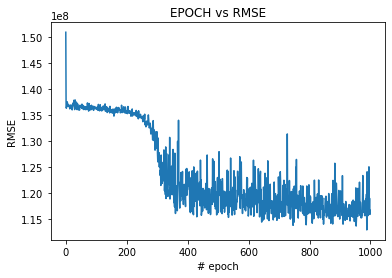

In [298]:
plt.plot(history.history['rmse'])
plt.xlabel('# epoch')
plt.ylabel('RMSE')
plt.title('EPOCH vs RMSE')
plt.show()

Text(0.5, 1.0, 'EPOCH vs MAE')

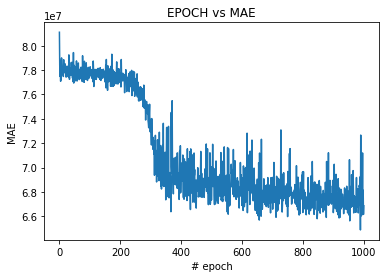

In [299]:
plt.plot(history.history['mean_absolute_error'])
plt.xlabel('# epoch')
plt.ylabel('MAE')
plt.title('EPOCH vs MAE')

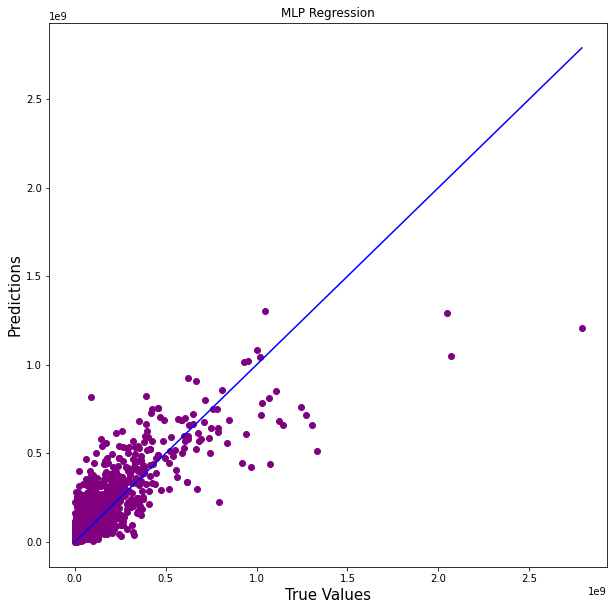

In [315]:
y_pred = model.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='purple')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('MLP Regression')
plt.show()

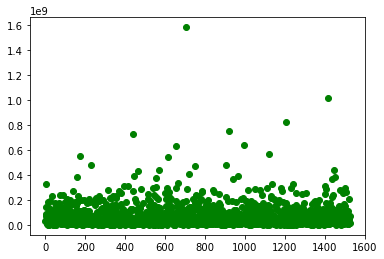

In [301]:
plt.plot(abs(np.array(y_test).reshape(-1, 1) - y_pred), c='g', marker='o',  linestyle='')

In [302]:
print("MLP Regressor r2 score  train:",r2_score(y_train, model.predict(X_train)))
print("MLP Regressor r2 score  test:",r2_score(y_test, y_pred))

MLP Regressor r2 score  train: 0.6496517343272787
MLP Regressor r2 score  test: 0.6289338826700656


In [190]:
from sklearn.neighbors import KNeighborsRegressor

# KNN Regressor

In [320]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

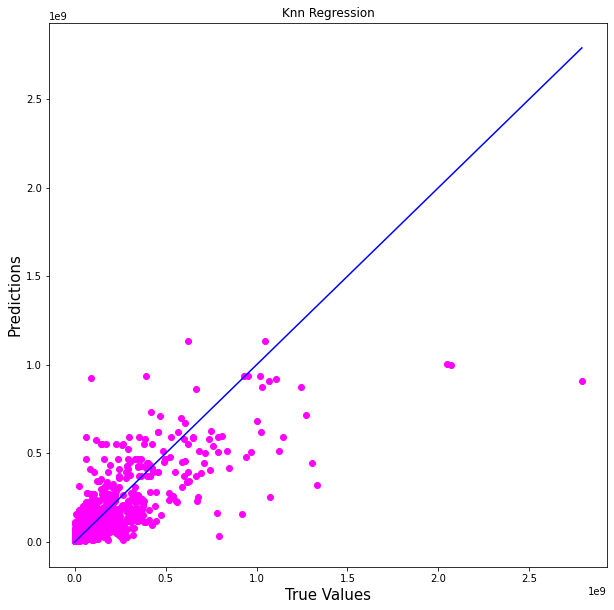

In [321]:
# knn.predict(X_test)-y_test
y_pred = knn.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='magenta')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Knn Regression')
plt.show()

In [322]:
mean_squared_error(y_pred, y_test, squared=False), mean_absolute_error(y_pred, y_test)

(126378561.04647042, 64130231.37903014)

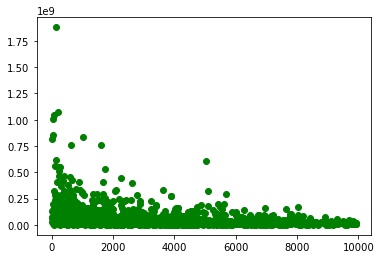

In [193]:
plt.plot(abs(y_test - y_pred), c='g', marker='o',  linestyle='')

In [194]:
print("Knn r2 score train:" ,r2_score(y_train, knn.predict(X_train)))
print("Knn r2 score test:" ,r2_score(y_test, y_pred))

Knn r2 score train: 0.709480975918271
Knn r2 score test: 0.60019373382864


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

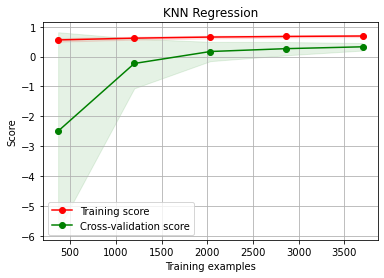

In [307]:
plot_learning_curve(knn, 'KNN Regression', x.drop('Revenue', axis=1), x['Revenue'])

# Ridge Regression

In [195]:
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1, normalize=True)

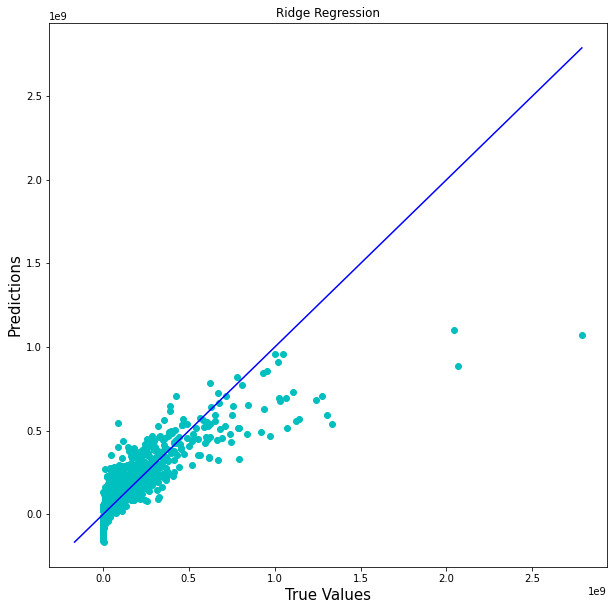

In [317]:
y_pred = ridge.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='c')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Ridge Regression")
plt.show()

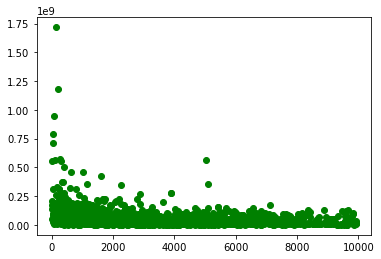

In [197]:
plt.plot(abs(y_test - y_pred), c='g', marker='o',  linestyle='')

In [198]:
print("ridge regression r2 score train:" ,r2_score(y_train, model.predict(X_train)))
print("ridge regression r2 score test :" ,r2_score(y_test, y_pred))

ridge regression r2 score train: 0.605704042747785
ridge regression r2 score test : 0.7140971110283509


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

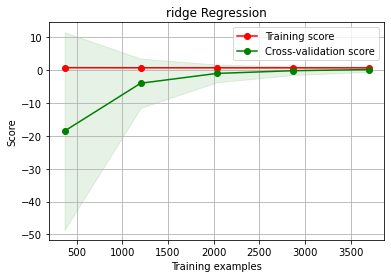

In [308]:
plot_learning_curve(ridge, 'ridge Regression', x.drop('Revenue', axis=1), x['Revenue'])

# Lasso Regression

In [199]:
lasso = Lasso(alpha=100, max_iter=10000).fit(X_train, y_train)

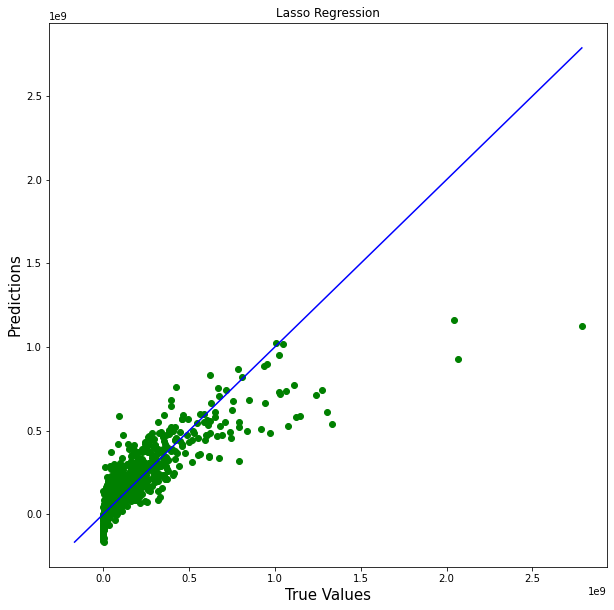

In [319]:
y_pred = lasso.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='g')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Lasso Regression")
plt.show()

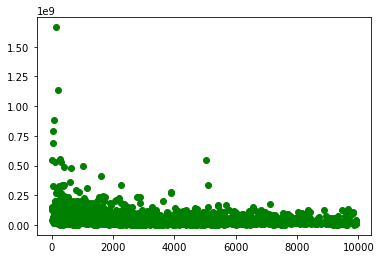

In [201]:
plt.plot(abs(y_test - y_pred), c='g', marker='o',  linestyle='')

In [202]:
print("lasso regression r2 score train:" ,r2_score(y_train, model.predict(X_train)))
print("lasso regression r2 score test :" ,r2_score(y_test, y_pred))

lasso regression r2 score train: 0.605704042747785
lasso regression r2 score test : 0.7173128031129512
